In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from tqdm import tqdm
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [2]:
N = 10
edges = []

cutoff = 0.5
theta = 0.9

points = np.random.rand(N, 2)

A = np.zeros((N,N))
W = np.zeros((N,N))

for i in range(N):
    for j in range(i+1, N):
        
        A[i,j] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff
        A[j,i] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff

        if A[i,j] == 1:
            edges.append((i,j))

In [3]:
def random_sheaf(
        V:int,
        d:int,
        edges:list
        ) -> np.array:

    E = len(edges)

    # Incidency linear maps

    F = {
        e:{
            e[0]:np.random.randn(d,d),
            e[1]:np.random.randn(d,d)
            } 
            for e in edges
        }                                           

    # Coboundary maps

    B = np.zeros((d*E, d*V))                        

    for i in range(len(edges)):

        # Main loop to populate the coboundary map

        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u           
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    L_f = B.T @ B

    return L_f

In [4]:
d = 10
Lf = random_sheaf(N, d, edges)

In [5]:
D = np.diag(np.diagonal(Lf))

In [6]:
#Lf = fractional_matrix_power(D, -0.5) @ Lf @ fractional_matrix_power(D, -0.5)

In [6]:
# Data generation 
np.random.seed(42)
M = 1000
X = np.random.randn(N*d,M)

# Tikhonov inspired filtering

Lambda, U = np.linalg.eig(Lf)
H = 1/(1 + 10*Lambda)

# Filter the signal accordingly to the true sheaf laplacian

Y = U @ np.diag(H) @ U.T @ X

# Normalize data
Y = np.apply_along_axis(lambda d: d/np.linalg.norm(d), axis=0, arr=Y)

# Add noise
Y += np.random.normal(0, 10e-2, size=Y.shape)

# Remap the signals back on each node

signals = {
    node: Y[node*d:(node + 1)*d,:]
    for node in range(N)
    }

In [8]:
'''
def groupOMP(Y, D, K):
    
    S = []  # List to store selected atom indices
    X = np.zeros((D.shape[1], Y.shape[1]))  # Coefficient matrix
    R = Y  # Residual matrix
    iters = 0

    while iters < K:
        # Step 1: Select the atom with the maximum correlation
        correlations = np.linalg.norm(D.T @ R, axis=1)
        selected_atom = np.argmax(correlations)
        S.append(selected_atom)

        # Step 2: Extract the dictionary subset for the selected atoms
        dic = D[:, S]

        # Step 3: Solve the least squares problem for the coefficients
        X_subset = np.linalg.pinv(dic) @ Y

        # Step 4: Update the coefficients in X
        X[S, :] = X_subset  # Update only the rows corresponding to S

        # Step 5: Update the residuals
        R = Y - D @ X

        iters += 1

    return X
'''

'\ndef groupOMP(Y, D, K):\n    \n    S = []  # List to store selected atom indices\n    X = np.zeros((D.shape[1], Y.shape[1]))  # Coefficient matrix\n    R = Y  # Residual matrix\n    iters = 0\n\n    while iters < K:\n        # Step 1: Select the atom with the maximum correlation\n        correlations = np.linalg.norm(D.T @ R, axis=1)\n        selected_atom = np.argmax(correlations)\n        S.append(selected_atom)\n\n        # Step 2: Extract the dictionary subset for the selected atoms\n        dic = D[:, S]\n\n        # Step 3: Solve the least squares problem for the coefficients\n        X_subset = np.linalg.pinv(dic) @ Y\n\n        # Step 4: Update the coefficients in X\n        X[S, :] = X_subset  # Update only the rows corresponding to S\n\n        # Step 5: Update the residuals\n        R = Y - D @ X\n\n        iters += 1\n\n    return X\n'

In [7]:
def ADMM_GroGlobLocSparseCoder(Y, U, V, d, mu, Lambda, rho, MAXITER = 100):

    def prox21(X, 
           gamma):
    
        def prox21_col(x,
                    gamma):
            return ( 1 - gamma / (np.max([np.linalg.norm(x), gamma])) ) * x
    
        return np.apply_along_axis(prox21_col, axis = 1, arr = X, gamma = gamma)
    
    # Variable initialization
    S = np.random.randn(U.shape[1], Y.shape[1])
    Z = np.random.randn(U.shape[1], Y.shape[1])
    M = np.random.randn(U.shape[1], Y.shape[1])

    # Precomputations 
    Phi = U.T
    Theta = U.T @ U + rho * np.eye(U.shape[1])

    for v in range(V):

        Pv = np.zeros((d, U.shape[0]))

        for j in range(d):
            Pv[j, v*d + j] = 1

        Phi += mu[v] * U.T @ Pv.T @ Pv
        Theta += mu[v] * U.T @ Pv.T @ Pv @ U
    
    Theta = np.linalg.inv(Theta)

    # Main loop
    for _ in range(MAXITER):
        S = Theta @ (Phi @ X + rho*(Z - M))
        Z = prox21(S + M, Lambda/rho)
        M = M + (S - Z)

    return S

In [8]:
def GreedySelection(edges, nodes, d, maps, D, X):
    
    energies = {}
    Y_hat = D @ X
    signals = {node: Y_hat[node*d : (node+1)*d, :] for node in nodes}

    for edge in edges:

        u = edge[0]
        v = edge[1]

        energies[edge] = np.linalg.norm(maps[edge][u] @ signals[u] - maps[edge][v] @ signals[v])

    return [edge for edge in edges if edge != max(energies, key = energies.get)]

In [9]:
def KKTLaplacianUpdate(D, X, d, edges, N, Q, Y = None):
       
    def premultiplier(Xu, Xv):
        uu = np.linalg.pinv(Xu @ Xu.T)
        uv = Xu @ Xv.T
        vv = Xv @ Xv.T
        vu = Xv @ Xu.T

        return (uu, uv, vv, vu)

    def chi_u(uu, uv, vv, vu):

        return (uu @ uv + np.eye(uu.shape[0])) @ (np.linalg.pinv(vu @ uu @ uv - vv) @ vu - np.eye(uu.shape[0])) @ uu 

    def chi_v(uu, uv, vv, vu):

        return (uu @ uv + np.eye(uu.shape[0])) @ (np.linalg.pinv(vu @ uu @ uv - vv) @ vu)

    T = 0
    if Y is None:
        Y = D @ X
        
    maps_ = {
        edge : {
            edge[0] : np.zeros((d,d)),
            edge[1] : np.zeros((d,d))
        }
    for edge in edges
    }

    for e in edges:
        
        u = e[0]
        v = e[1]

        X_u = Y[u*d:(u+1)*d,:]
        X_v = Y[v*d:(v+1)*d,:]
        
        uu, uv, vv, vu = premultiplier(X_u, X_v)

        maps_[e][u] = chi_u(uu, uv, vv, vu)
        maps_[e][v] = chi_v(uu, uv, vv, vu)
        
        T += np.trace(maps_[e][u]) + np.trace(maps_[e][v])

    maps_ = {
        edge : {
            edge[0] : Q/T * maps_[edge][edge[0]],
            edge[1] : Q/T * maps_[edge][edge[1]]
        }
    for edge in edges
    }

    E = len(edges)
    B_hat = np.zeros((d*E, d*N))

    for i, edge in enumerate(edges):

        u = edge[0] 
        v = edge[1] 

        B_u = maps_[edge][u]
        B_v = maps_[edge][v]

        B_hat[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B_hat[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f = B_hat.T @ B_hat

    return L_f, maps_

In [10]:
def MapsSolver(Y, d, edges, N):

    obj = 0
    trace = 0

    Fs = {
        edge: {
            edge[0]:None,
            edge[1]:None
        }
        for edge in edges
    }

    # Loop over edges to define variables and construct objective
    for edge in edges:
        u = edge[0]
        v = edge[1]

        Y_u = Y[u*d:(u+1)*d, :]
        Y_v = Y[v*d:(v+1)*d, :]

        # Define optimization variables for each edge
        Fs[edge][u] = cp.Variable((d, d))
        Fs[edge][v] = cp.Variable((d, d))

        # Update objective and trace
        obj += cp.norm(Fs[edge][u] @ Y_u - Fs[edge][v] @ Y_v, 'fro')**2
        trace += cp.trace(Fs[edge][u]) + cp.trace(Fs[edge][v])

    # Define the trace constraint
    trace_constraint = (trace == N)

    # Define the problem
    problem = cp.Problem(cp.Minimize(obj), [trace_constraint])

    # Solve the problem
    problem.solve(solver=cp.MOSEK,
                  mosek_params = { 'MSK_IPAR_INTPNT_SOLVE_FORM':   'MSK_SOLVE_PRIMAL' })

    # Return the solution
    return Fs

def ImplicitLaplacianUpdate(D, X, d, edges, N, Q, Y = None):    
    T = 0
    if Y is None:
        Y = D @ X

    maps_ = MapsSolver(Y, d, edges, Q)

    for edge in edges:
        T += np.trace(maps_[edge][edge[0]].value) + np.trace(maps_[edge][edge[1]].value)

    maps = {
        edge: {
            edge[0] : Q/T * maps_[edge][edge[0]].value,
            edge[1] : Q/T * maps_[edge][edge[1]].value
        }
        for edge in edges
    }

    Lf = np.zeros((d*N, d*N))
    
    for edge in edges:

        u = edge[0] 
        v = edge[1] 

        Lf[u*d:(u+1)*d,u*d:(u+1)*d] += maps[edge][u].T @ maps[edge][u]
        Lf[v*d:(v+1)*d,v*d:(v+1)*d] += maps[edge][v].T @ maps[edge][v]
        Lf[u*d:(u+1)*d,v*d:(v+1)*d] = - maps[edge][u].T @ maps[edge][v]
        Lf[v*d:(v+1)*d,u*d:(u+1)*d] = - maps[edge][v].T @ maps[edge][u]

    return Lf, maps


In [11]:
def LaplacianLearningPipeline(
        Y, 
        E0,
        K, 
        d, 
        N, 
        Q = 1e2,
        KKT = False):
    
    # Initialization - Full graph with Gaussian random maps

    edges = list(combinations(range(N),2))

    if KKT:
        Lf, maps = KKTLaplacianUpdate(None, None, d, edges, N, Q, Y)
    else:
        Lf, maps = ImplicitLaplacianUpdate(None, None, d, edges, N, Q, Y)

    #Lf = fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5) @ Lf @ fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5)

    # Main loop - First try with a priori knowledge of the number of connections
    loss = []

    while len(edges) > E0:
        print('Removing one edge...')
        _, U = np.linalg.eig(Lf)
        X = ADMM_GroGlobLocSparseCoder(Y, U, N, d, np.ones(N), 0.0075, 1)
        
        # Greedy deleting one edge from the graph
        edges = GreedySelection(edges, range(N), d, maps, U, X)

        # Rebuilding the sheaf laplacian on the new graph
        if KKT:
            Lf, maps = KKTLaplacianUpdate(U, X, d, edges, N, Q)
        else:
            Lf, maps = ImplicitLaplacianUpdate(U, X, d, edges, N, Q)

        #Lf = fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5) @ Lf @ fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5)
        loss.append(np.trace(Y.T @ Lf @ Y))
        
    return Lf, edges, loss, maps, D, X 

In [12]:
E0 = len(edges)
print(E0)

17


In [24]:
L_hat, edges_, loss, maps, D, X = LaplacianLearningPipeline(Y, E0, 100, d, N, KKT = False)

Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...
Removing one edge...


In [14]:
X.shape

(100, 1000)

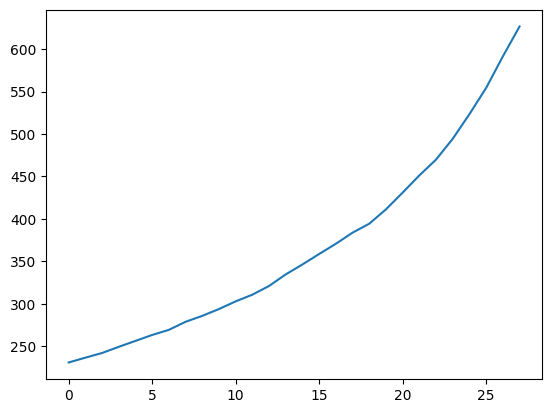

In [25]:
plt.plot(loss)

In [26]:
EDG = set(edges)
EDG_HAT = set(edges_)

In [27]:
len(EDG.intersection(EDG_HAT))/E0

0.29411764705882354

In [28]:
np.trace(Y.T @ Lf @ Y)

38303.13399615786

In [29]:
np.trace(Y.T @ L_hat @ Y)

626.5145364590737

In [30]:
np.linalg.norm(L_hat)

3.7827237832050695

Best result so far!